In [1]:
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import glob
import tools21cm as t2c
plt.rcParams['font.size'] = 12
save = False

plt.rcParams.update({"text.usetex": True,'font.family': 'serif','font.size':10})

In [2]:
# Parameters
numslices = 10
N = 256
srcplane = 127
boxsize = 1620.22035 # kpc
dr = boxsize / N

# Instructions
Run the script `run_test.py` twice, as follows:
```
mkdir test_results
python run_test.py --gpu -mode coarse
mv test_results results_coarse
mkdir test_results
python run_test.py --gpu -mode fine
mv test_results results_fine
```
Caution: the "fine" output will take $\sim$ 14 Gb of disk space

In [3]:
redshifts = np.array([9.0,8.238,7.605,7.071,6.613,6.214,5.863,5.552,5.274,5.024,4.797])

In [4]:
# Load Files
files_fine =   np.flip(sorted(glob.glob("./results_fine/xfrac*.pkl")))
files_coarse = np.flip(sorted(glob.glob("./results_coarse/xfrac*.pkl")))

slices_coarse = np.empty((len(files_coarse),129))
for i,fn in enumerate(files_coarse):
    with open(fn,"rb") as f:
        slices_coarse[i] = pkl.load(f)[srcplane:,srcplane,srcplane]
        
slices_fine = np.empty((len(files_fine),129))
for i,fn in enumerate(files_fine):
    with open(fn,"rb") as f:
        slices_fine[i] = pkl.load(f)[srcplane:,srcplane,srcplane]

In [5]:
# Analytical Solution
kpc = 3.086e21
year = 3.15576E+07
Ngamma = 1e54
nH = 1.87e-4
alpha_B = 2.59e-13

kpc_in_km = 3.0857e16 # km
myr_in_s = 31557600000000 # s

r_S = ((3*Ngamma)/(4*np.pi*alpha_B*nH**2))**(1./3) / kpc
t_rec = 1.0 / (alpha_B*nH*year*1e6)
print("r_S = ",r_S," kpc")
print("t_rec = ",t_rec," Myr")
def r_I(t):
    return r_S * (1.0 - np.exp(-t/t_rec))**(1./3)
def v_I(t):
    return kpc_in_km/myr_in_s * r_S/(3*t_rec) * (np.exp(-t/t_rec))/(1.0 - np.exp(-t/t_rec))**(2./3)

r_S =  964.3770859478684  kpc
t_rec =  654.2664673678886  Myr


In [6]:
tt = np.linspace(0,500,200,endpoint=True)
tt_ = np.linspace(0,500,11,endpoint=True)
tt_fine = np.linspace(0,500,101,endpoint=True)
r_analytical = r_I(tt)
v_analytical = v_I(tt[1:])
x = np.linspace(0,boxsize/2,129)

In [7]:
# Find position of ionization front by interpolation
# flip() is used because np.interp works on monotonically increasing functions only
front_pos_coarse = np.empty(11)
front_pos_fine = np.empty(101)
for k in range(11):
    front_pos_coarse[k] = np.interp(0.5,np.flip(slices_coarse[k]),np.flip(x))
for k in range(101):
    front_pos_fine[k] = np.interp(0.5,np.flip(slices_fine[k]),np.flip(x))

In [8]:
# Compute the I-front velocity using the approach of M06
t_ave = []
t_ave_fine = []
front_vel_fine = []
front_vel_coarse = []
for k in range(1,len(tt_)):
    j = 1
    while (front_pos_coarse[k]-front_pos_coarse[k-j]) < dr:
        j+=1
    front_vel_coarse.append(kpc_in_km/myr_in_s * (front_pos_coarse[k]-front_pos_coarse[k-j]) / (tt_[k]-tt_[k-j]))
    tavei = (tt_[k]+tt_[k-j])/2
    t_ave.append(tavei)
for k in range(1,len(tt_fine)):
    j = 1
    while (front_pos_fine[k]-front_pos_fine[k-j]) < dr:
        j+=1
    front_vel_fine.append(kpc_in_km/myr_in_s * (front_pos_fine[k]-front_pos_fine[k-j]) / (tt_fine[k]-tt_fine[k-j]))
    tavei = (tt_fine[k]+tt_fine[k-j])/2
    t_ave_fine.append(tavei)

In [9]:
# Error ratios
raderr_coarse = front_pos_coarse / r_I(tt_)
raderr_fine = front_pos_fine / r_I(tt_fine)

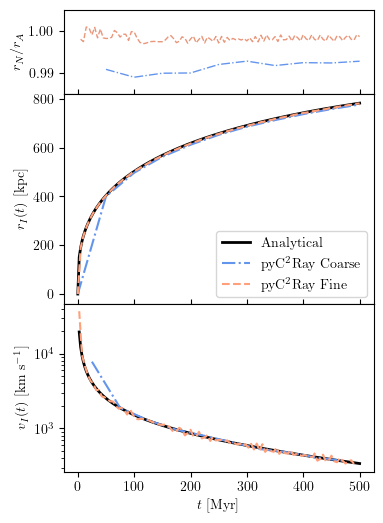

In [10]:
fig, ax = plt.subplots(3,1,figsize=(4,6),sharex=True,height_ratios=[2,5,4])

ax[0].plot(tt_[1:],raderr_coarse[1:],'-.',lw=1,color='cornflowerblue')
ax[0].plot(tt_fine[1:],raderr_fine[1:],'--',lw=1,color='darksalmon')
ax[0].set_ylabel("$r_{N}/r_{A}$")
ax[0].set_ylim(0.985,1.005)

ax[1].plot(tt,r_analytical,color='black',label="Analytical",lw=2)
ax[1].plot(tt_,front_pos_coarse,'-.',label="pyC$^2$Ray Coarse",color='cornflowerblue')
ax[1].plot(tt_fine,front_pos_fine,'--',ms=6,label="pyC$^2$Ray Fine",color='lightsalmon')


ax[1].set_ylabel("$r_I(t)$ [kpc]")
ax[1].tick_params(top=True)
ax[1].legend()

ax[2].semilogy(tt[1:],v_analytical,color='black',label="Analytical",lw=2)
ax[2].semilogy(t_ave,front_vel_coarse,'-.',label="pyC$^2$Ray Coarse",color='cornflowerblue')
ax[2].semilogy(t_ave_fine,front_vel_fine,'--',label="pyC$^2$Ray Fine",color='lightsalmon')

ax[2].set_xlabel("$t$ [Myr]")
ax[2].set_ylabel("$v_I(t)$ [km s$^{-1}$]")
ax[2].tick_params(top=True)
#ax[1].legend()
fig.subplots_adjust(hspace=0)

In [11]:
#fig.savefig("test1_3p_new.eps",bbox_inches='tight')
fig.savefig("test1_Ifront.png",bbox_inches='tight',dpi=400)